<a href="https://colab.research.google.com/github/bhavyachinni/Age-Detection-insulators/blob/master/Aging_of_Inulators_using_Hyperspectral_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pavia-university-hsi:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1450588%2F2398947%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240418%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240418T025203Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40c073a476aa59d2bafcb30341ecfad8b9f25440637a1d38fcf9ab4e718ffd9fb508882dd868a55c5b3d5f119bdb01237173f18df447e25cfe1deab30eb791f96dba1c04ee5bf0a6e7c7b710dfb83ee920534069716446dc32fdbeb0c275568a7ca21c27b9eef26b48b77c79024bdaefc004860b197536c64b987bde4d8c9b78b403d1982495799ca7288a3620622366350edc64be9c0aa169fe0ec1644f921e40c1413791ff360fc60ef54018cc116bbfad63c5234d9fb023101da9d039c235118e154b67f9fb28785a2b58f8c983fdd5d5a0c08b16797d8b313d44f20b47c12254a7943c3db44e54ea808609dddd31d3f0629f2c300bfe892f3ef04cf93c22'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34828761 bytes downloaded
Downloaded and uncompressed: pavia-university-hsi
Data source import complete.


In [ ]:
! pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

In [ ]:
data = loadmat('../input/pavia-university-hsi/PaviaU.mat')['paviaU']

gt = loadmat('../input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

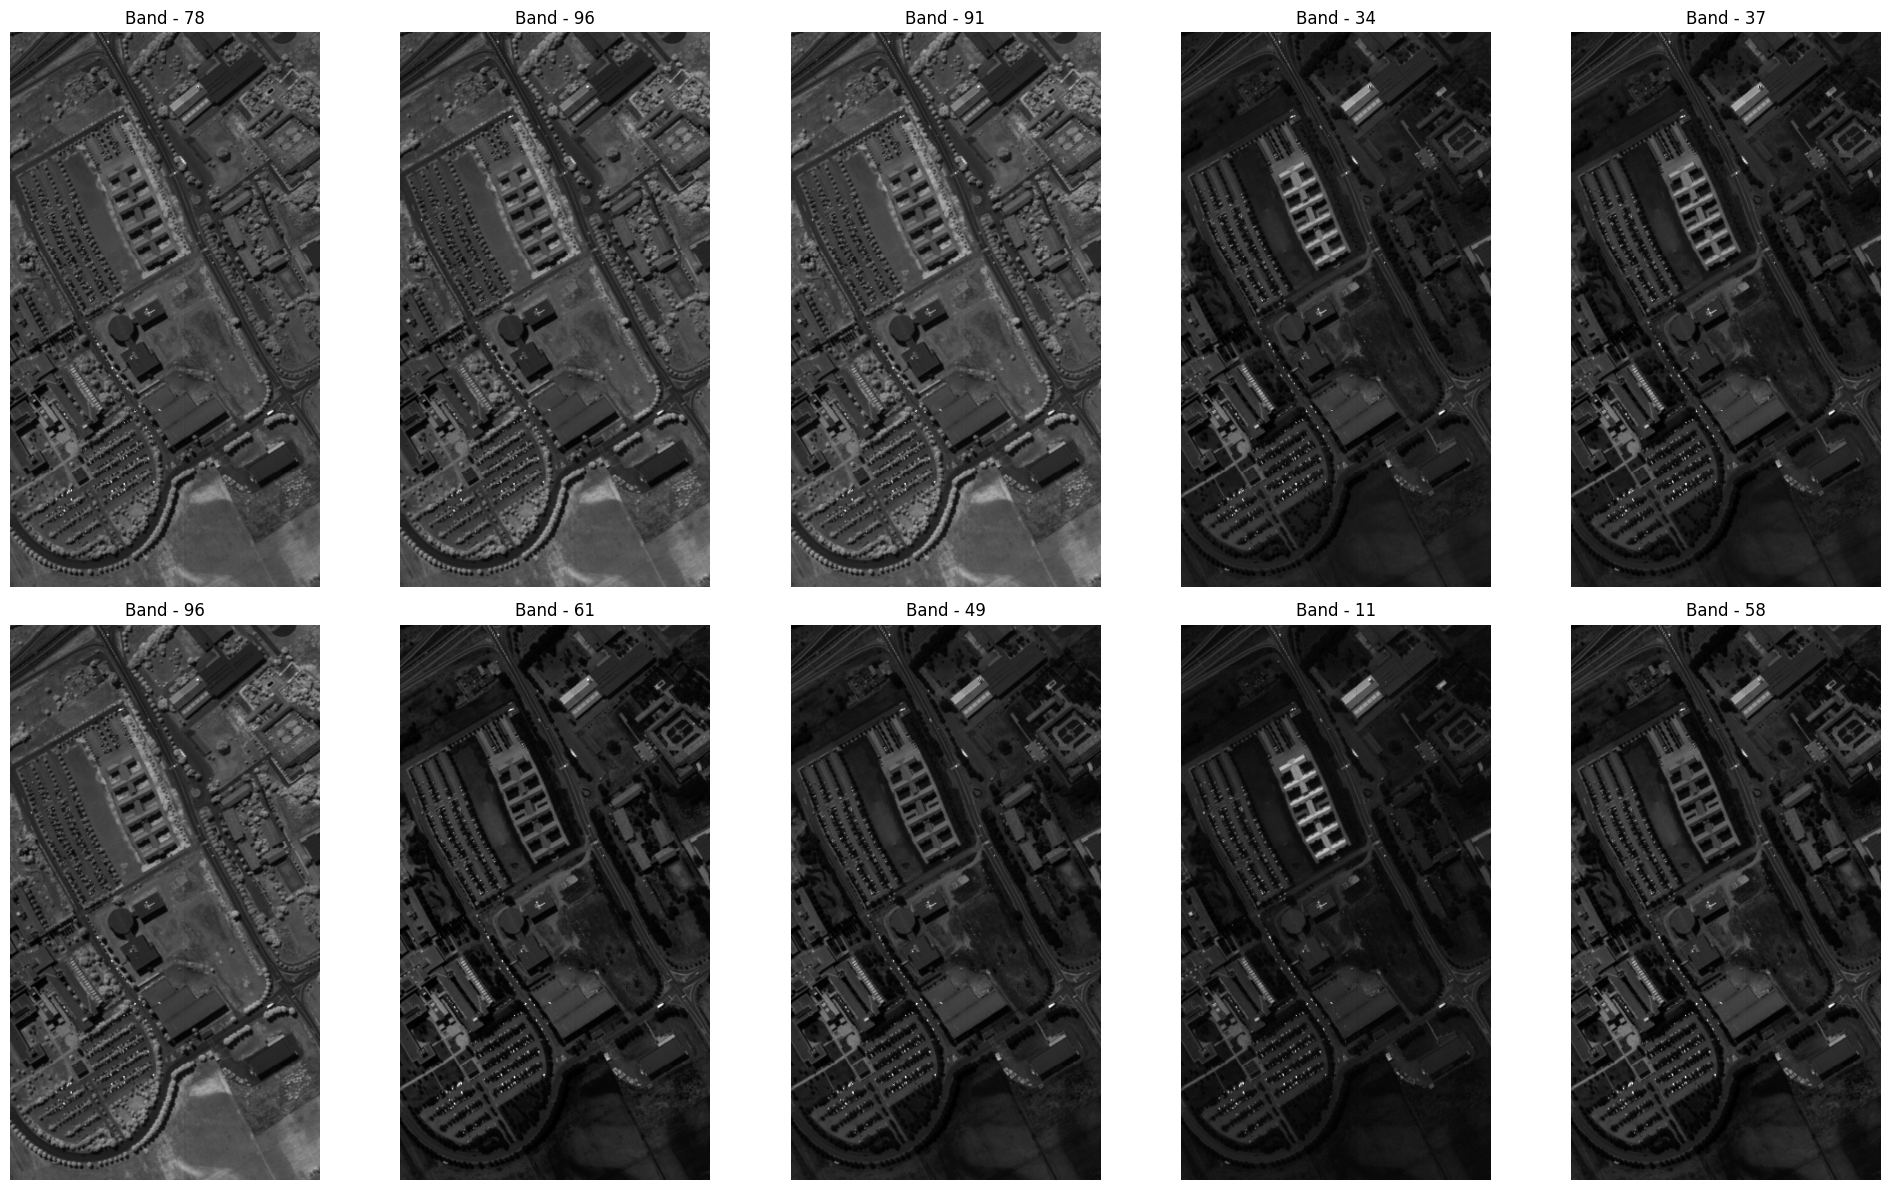

In [ ]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()

plt.show()

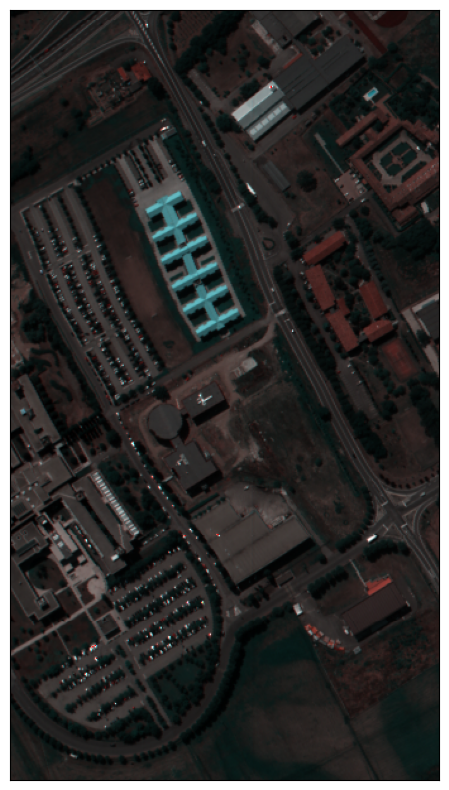

In [ ]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize=(12, 10))

plt.show()

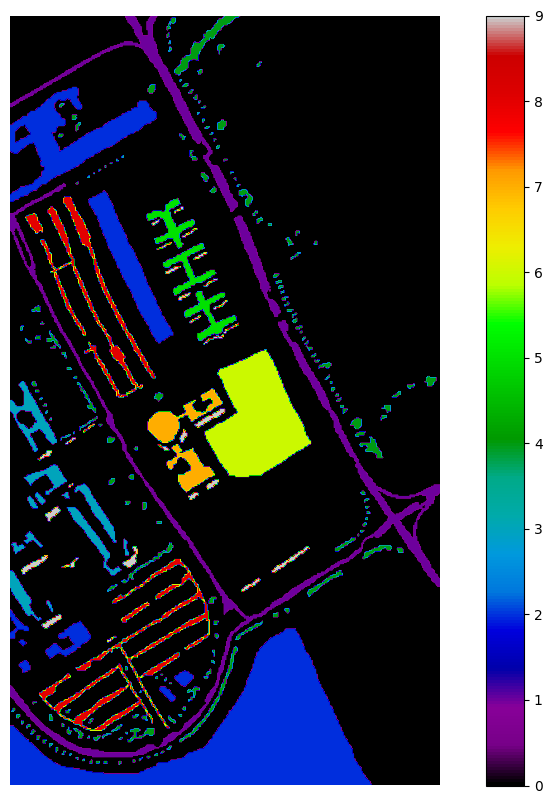

In [ ]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

In [ ]:
X = df[df['class']!=0].iloc[:, :-1].values

y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values ,
                                  num_classes= np.unique(gt).shape[0],
                                  dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, stratify = y)

print(f"Train Data: {X_train.shape}\nTest Data: {X_test.shape}")

Train Data: (29943, 103)
Test Data: (12833, 103)


In [ ]:
model = Sequential(name='Pavia_University')

model.add(Input(shape = X_train[0].shape, name = 'Input_Layer'))

model.add(BatchNormalization(name = 'BatchNormalization'))

model.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))

model.add(Dropout(rate = 0.2, name = 'Dropout1',))

model.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))

model.add(Dropout(rate = 0.2, name = 'Dropout2'))

model.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))

model.add(Dense(units = y_train.shape[1], activation= 'softmax', name = 'Output_Layer'))

model.summary()

Model: "Pavia_University"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchN  (None, 103)               412       
 ormalization)                                                   
                                                                 
 Layer1 (Dense)              (None, 128)               13312     
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                                  

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x = X_train,
          y = y_train,
          validation_data = (X_test, y_test),
          epochs = 100,
          callbacks = [es, checkpoint])

Epoch 1/100
929/936 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.7006
Epoch 1: val_loss improved from inf to 0.48105, saving model to Pavia_University_Model.h5
936/936 [==============================] - 12s 6ms/step - loss: 0.8244 - accuracy: 0.7010 - val_loss: 0.4811 - val_accuracy: 0.8051
Epoch 2/100
  7/936 [..............................] - ETA: 8s - loss: 0.6506 - accuracy: 0.7411 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


929/936 [============================>.] - ETA: 0s - loss: 0.5724 - accuracy: 0.7811
Epoch 2: val_loss improved from 0.48105 to 0.40812, saving model to Pavia_University_Model.h5
936/936 [==============================] - 5s 5ms/step - loss: 0.5715 - accuracy: 0.7817 - val_loss: 0.4081 - val_accuracy: 0.8368
Epoch 3/100
931/936 [============================>.] - ETA: 0s - loss: 0.5234 - accuracy: 0.7990
Epoch 3: val_loss improved from 0.40812 to 0.38537, saving model to Pavia_University_Model.h5
936/936 [==============================] - 5s 5ms/step - loss: 0.5228 - accuracy: 0.7991 - val_loss: 0.3854 - val_accuracy: 0.8410
Epoch 4/100
926/936 [============================>.] - ETA: 0s - loss: 0.4599 - accuracy: 0.8195
Epoch 4: val_loss improved from 0.38537 to 0.35857, saving model to Pavia_University_Model.h5
936/936 [==============================] - 6s 6ms/step - loss: 0.4598 - accuracy: 0.8194 - val_loss: 0.3586 - val_accuracy: 0.8410
Epoch 5/100
931/936 [=========================

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x = X_train,
          y = y_train,
          validation_data = (X_test, y_test),
          epochs = 100,
          callbacks = [es, checkpoint])

In [ ]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

In [ ]:
pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees',
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen',
                 '8. Self-Blocking Bricks', '9. Shadows']))

In [ ]:
plt.figure(figsize = (10,7))

classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [ ]:
l = []

for i in tqdm(range(df.shape[0])):
  if df.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(np.argmax(model.predict(df.iloc[i, :-1].values.reshape(-1, 103)), 1))

q = np.array(l).reshape(gt.shape).astype('float')

plot_data(q)